In [2]:
from src.esn import ESN
from src.utils import config, helper
from src.conceptors import compute_conceptor, loading_ridge_report, ridge_regression

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Autoconceptor
This notebook reproduces the experiements described in Jaeger 2014, section 3.14.3: Autoconceptive Reservoir as Content-Addressable Memories.

In [29]:
prng = np.random.default_rng(1001)

In [30]:
esnConfig = config.ESNConfig(
    input_size=1,
    reservoir_size=100,
    output_size=1,
    feedback=False,
    spectral_radius=0.6,
    init_weights='normal',
    init_weights_b='normal',
    init_weights_in='normal',
    init_weights_density=0.1,
    init_weights_in_density=1, #percentage of nonzero reservoir weights
    init_weights__args={'loc': 0., 'scale': 1.},
    init_weights_b__args={'loc': 0., 'scale': 0.5},
    init_weights_in__args={'loc': 0., 'scale': 1.5},
)

In [31]:
esn = ESN(esnConfig, prng)

## Loading
Learning of the readouts and reservoir weights.

In [32]:
T_INITIAL_WASHOUT = 100 # washout before cueing procedure
T_LOADING = 50
T_pattern = T_INITIAL_WASHOUT + T_LOADING
LOADING_REGULARIZER = 1e-1 #regularizer ridge regression D
READOUT_REGULARIZER = 0 #regularizer ridge regression readouts

In [33]:
ut = [
    helper.n_periodic(4, T_pattern, np.random.default_rng(27)),
    helper.n_periodic(4, T_pattern, np.random.default_rng(42)),
    helper.n_periodic(4, T_pattern, np.random.default_rng(7)),
    helper.n_periodic(4, T_pattern, np.random.default_rng(40)),
    #helper.n_sine(8.83, T_pattern, phase=0.25),
    #helper.n_sine(9.83, T_pattern, phase=0.)
]

In [34]:
xt, yt = list(zip(*map(esn.harvest_states, ut)))
X = np.concatenate([x[T_INITIAL_WASHOUT:, :] for x in xt])
U = np.concatenate([u[T_INITIAL_WASHOUT:, :] for u in ut])

### Learning of the readouts

In [35]:
Y_T = U.copy()
#w_before_training = esn.w
esn.update_weights(X, U, Y_T, alpha=READOUT_REGULARIZER)

In [36]:
_, yt_trained = list(zip(*map(esn.harvest_states, ut)))

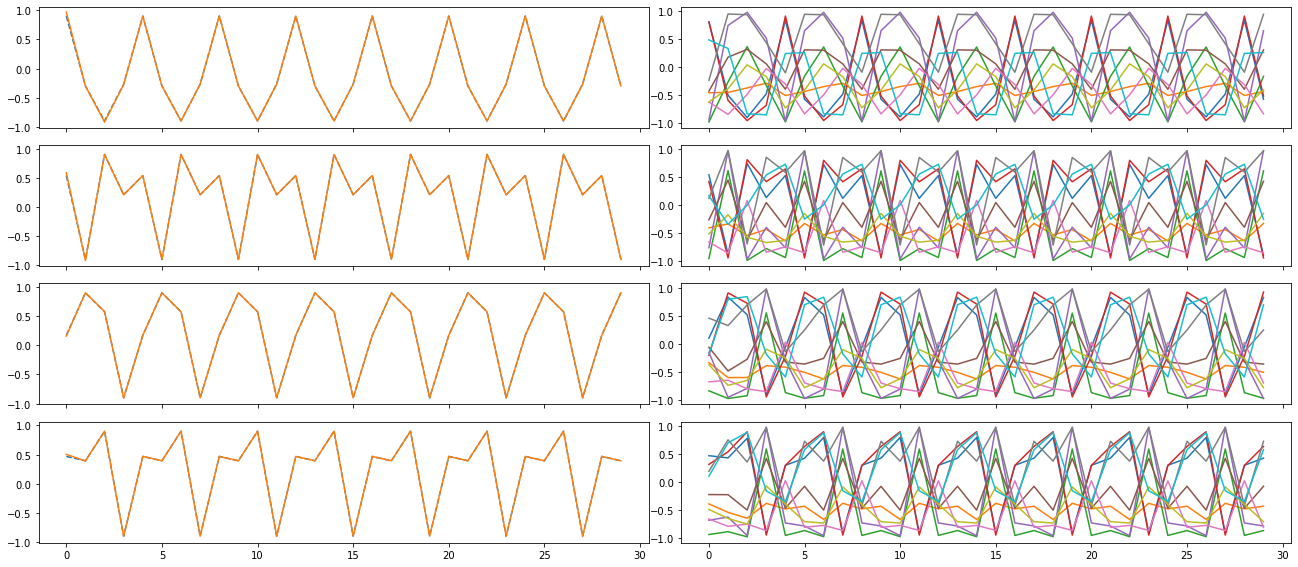

In [37]:
fig, ax = plt.subplots(len(ut), 2, figsize=(18, 2*len(ut)), sharex=True, sharey='col')
for i in range(len(ut)):
    T_begin, T_end = 0, 30
    ax[i][0].plot(ut[i][T_begin:T_end], ls='--')
    ax[i][0].plot(yt_trained[i][T_begin:T_end])
    ax[i][1].plot(xt[i][T_begin:T_end, :10])
plt.tight_layout()

### Loading of the patterns in the input simulation matrix D

In [38]:
X_ = helper.concatenate_patterns(xt, T_INITIAL_WASHOUT, shift=-1)

In [39]:
D_loaded = ridge_regression(X_, np.dot(esn.w_in, U.T).T, regularizer=LOADING_REGULARIZER)
esn.d = D_loaded.copy()

## Recall

In [40]:
T_WASHOUT = 100
T_CUE = 15
T_RECALL = 300
APERTURE = 10
LEARNING_RATE_CUE = 1e-3
LEARNING_RATE_RECALL = 1e-3


### Washout

In [41]:
ut0 = [u[:T_WASHOUT, :] for u in ut]
xt_ini, yt_ini = list(zip(*map(esn.harvest_states, ut0)))

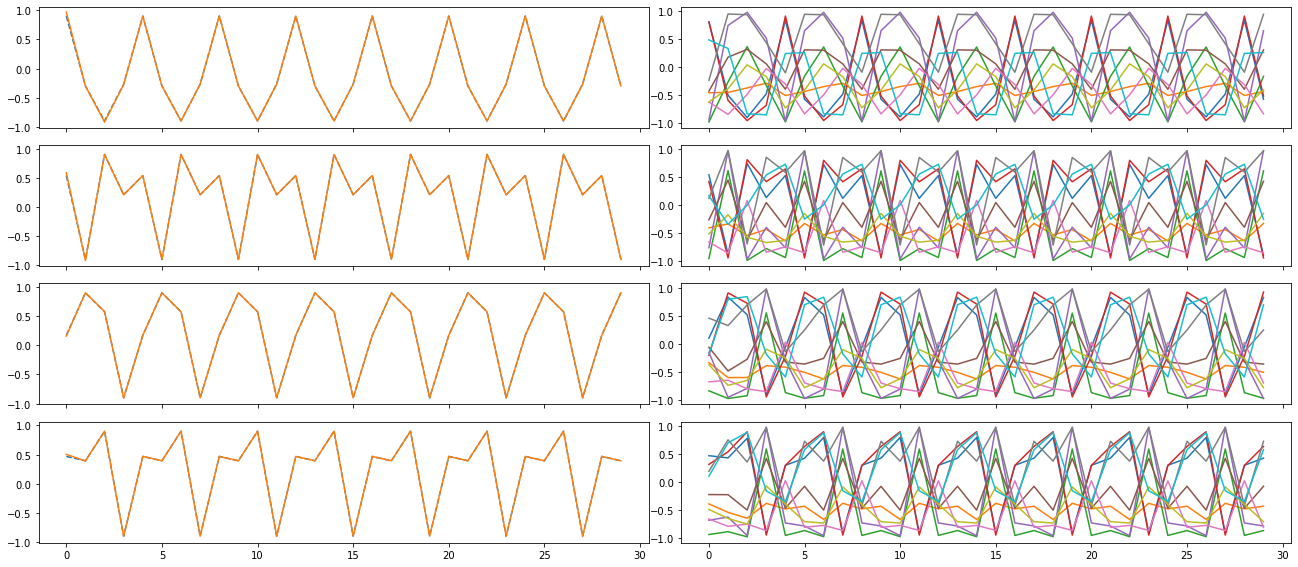

In [42]:
fig, ax = plt.subplots(len(ut0), 2, figsize=(18, 2*len(ut)), sharex=True, sharey='col')
for i in range(len(ut)):
    T_begin, T_end = 0, 30
    ax[i][0].plot(ut[i][T_begin:T_end], ls='--')
    ax[i][0].plot(yt_ini[i][T_begin:T_end])
    ax[i][1].plot(xt_ini[i][T_begin:T_end, :10])
plt.tight_layout()

### Cueing

In [43]:
ut1 = [u[:T_WASHOUT+T_CUE, :] for u in ut]
xt_cue, yt_cue, Ct_cue = list(zip(*[
    esn.cueing(ut1[i][T_WASHOUT:,:], LEARNING_RATE_CUE, APERTURE,
            x_init=xt_ini[i][-1,:][np.newaxis].T.copy(),
            y_init=yt_ini[i][-1,:].copy() ) 
    for i in range(len(ut))
]))

In [44]:
# Comparison with conceptor calculated with the correlation matrix
Ci = [
    compute_conceptor(xt_i[:, :], aperture=APERTURE)
    for xt_i in xt_cue
]

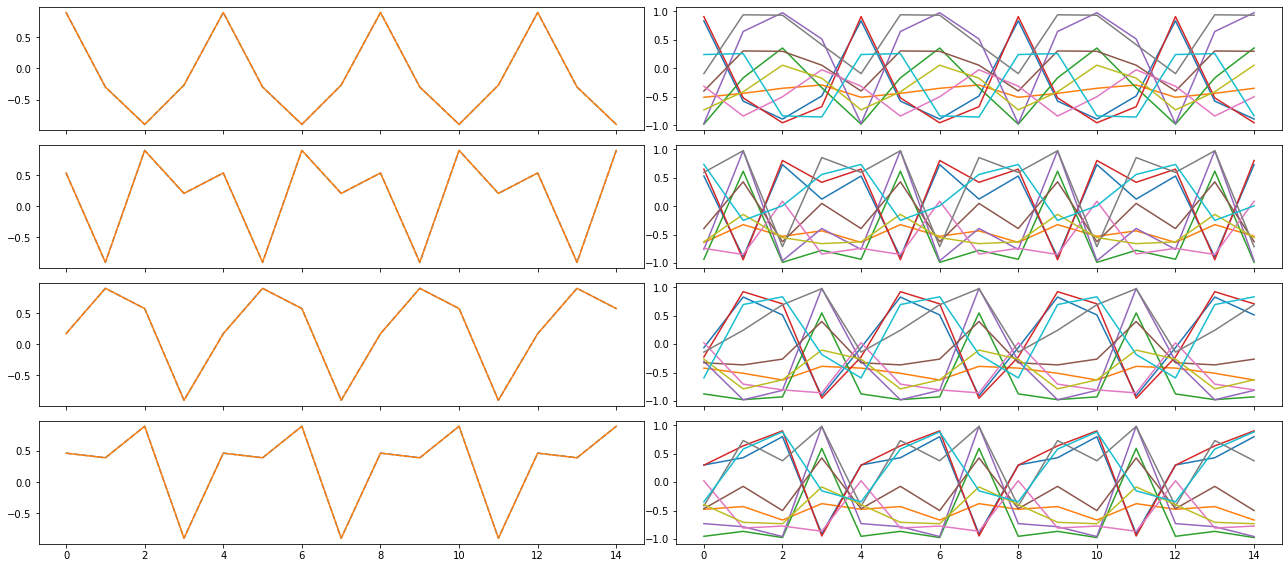

In [45]:
fig, ax = plt.subplots(len(ut), 2, figsize=(18, 2*len(ut)), sharex=True, sharey='col')
for i in range(len(ut)):
    T_begin, T_end = 0, 15
    ax[i][0].plot(ut[i][T_begin:T_end], ls='--')
    ax[i][0].plot(yt_cue[i][T_begin:T_end])
    ax[i][1].plot(xt_cue[i][T_begin:T_end, :10])
plt.tight_layout()

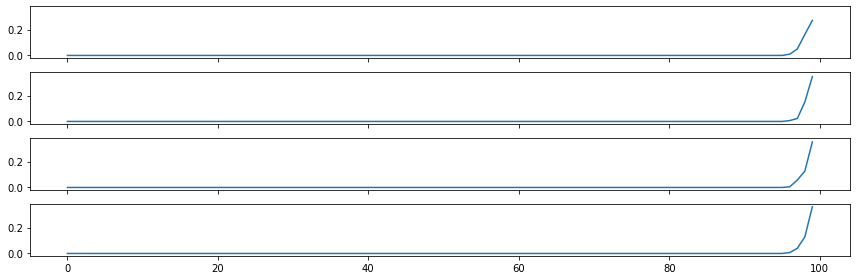

In [47]:
# Monitor the scaling values of C (after the cueing phase)
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(np.sort(abs(np.linalg.eig(Ct_cue[i][-1])[0])))
plt.tight_layout()

### Autonomous recall

Check or to explore C convergence dynamics

In [48]:
ut_zero = np.zeros((T_RECALL,1))
xt_recall, yt_recall, Ct_recall = list(zip(*[
    esn.recall(ut_zero.copy(), LEARNING_RATE_RECALL, APERTURE,
            x_init=xt_cue[i][-1,:][np.newaxis].T.copy(), 
            y_init=yt_cue[i][-1,:].copy(),
            # Conceptor calculated with correlation matrix during cueing
            #C_init=Ci[i].copy() 
            # Conceptor calculated during cueing with gradient descent
            C_init=Ct_cue[i][-1].copy()
              ) 
    for i in range(len(ut))
]))

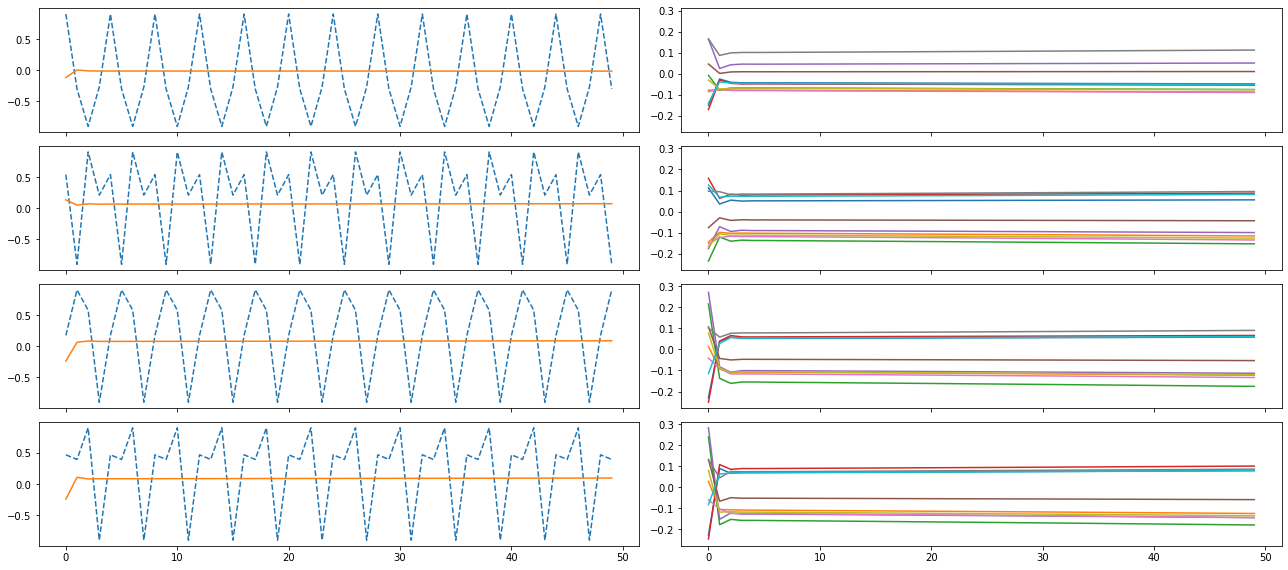

In [49]:
fig, ax = plt.subplots(len(ut), 2, figsize=(18, 2*len(ut)), sharex=True, sharey='col')
for i in range(len(ut)):
    T_begin, T_end = 0, 50
    ax[i][0].plot(ut[i][T_begin:T_end], ls='--')
    ax[i][0].plot(yt_recall[i][T_begin:T_end])
    ax[i][1].plot(xt_recall[i][T_begin:T_end, :10])
plt.tight_layout()

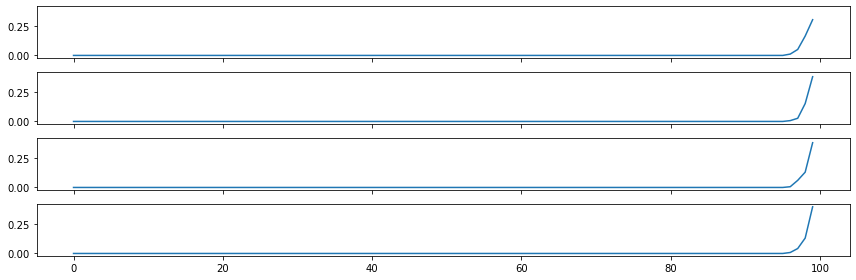

In [50]:
# Monitor the scaling values of C
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(np.sort(abs(np.linalg.eig(Ct_recall[i][0])[0])))
plt.tight_layout()

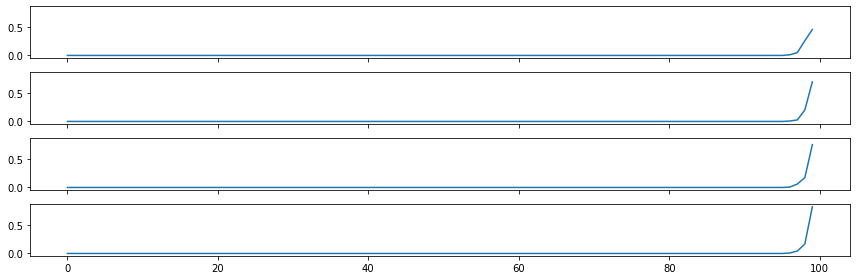

In [51]:
# Monitor the scaling values of C
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(np.sort(abs(np.linalg.eig(Ct_recall[i][-1])[0])))
plt.tight_layout()

# full_procedure (in one step using trainingConfig)

In [52]:
prng = np.random.default_rng(1234)

In [53]:
T_pattern = 150 
ut = [
    helper.n_periodic(4, T_pattern, np.random.default_rng(27)),
    helper.n_periodic(4, T_pattern, np.random.default_rng(42)),
    helper.n_periodic(4, T_pattern, np.random.default_rng(7)),
    helper.n_periodic(4, T_pattern, np.random.default_rng(40)),
    #helper.n_sine(8.83, T_pattern, phase=0.25),
    #helper.n_sine(9.83, T_pattern, phase=0.)
]

In [54]:
trainingConfig = config.TrainingConfig(
    washout=100,
    aperture=10,
    recall=150,
    cue=15,
    
    w_regularizer=1e-1,
    wout_regularizer=0,
    
    learning_rate_recall=1e-3,
    learning_rate_cue=1e-3
)

In [55]:
esnConfig = config.ESNConfig(
    input_size=1,
    reservoir_size=100,
    output_size=1,
    feedback=False,
    spectral_radius=0.6,
    init_weights='normal',
    init_weights_b='normal',
    init_weights_in='normal',
    init_weights_density=0.1,
    init_weights_in_density=1, #percentage of nonzero reservoir weights
    init_weights__args={'loc': 0., 'scale': 1.},
    init_weights_b__args={'loc': 0., 'scale': 0.5},
    init_weights_in__args={'loc': 0., 'scale': 1.5},
)

In [56]:
esn = ESN(esnConfig, prng)

In [57]:
xt_recall, yt_recall, Ct_recall = esn.full_procedure_auto(ut, trainingConfig)

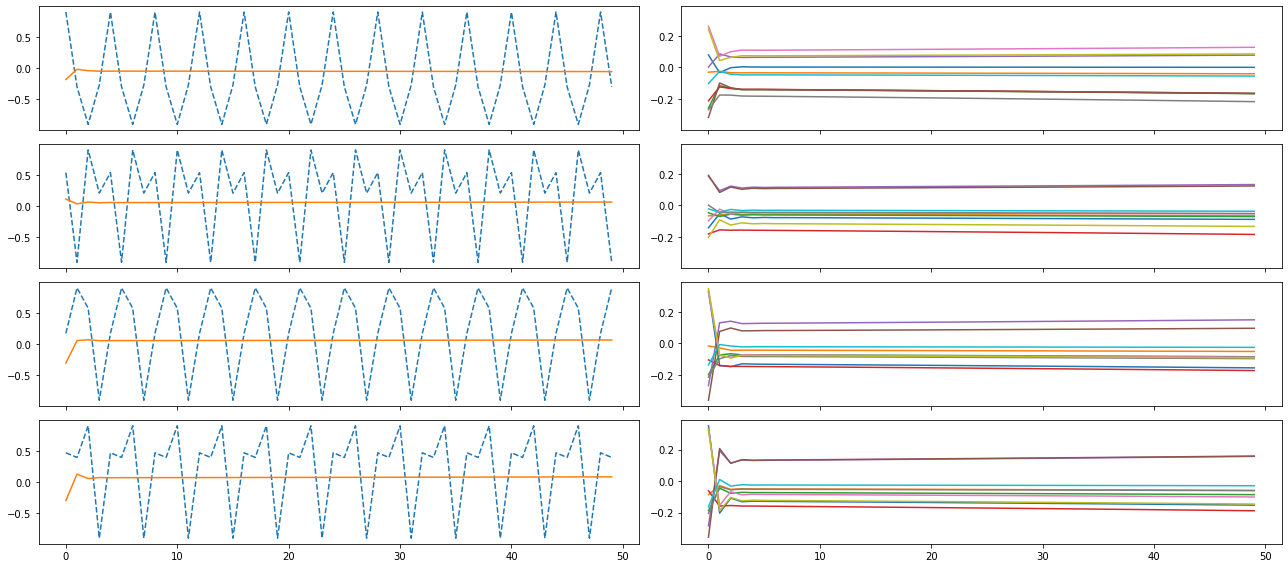

In [58]:
fig, ax = plt.subplots(len(ut), 2, figsize=(18, 2*len(ut)), sharex=True, sharey='col')
for i in range(len(ut)):
    T_begin, T_end = 0, 50
    ax[i][0].plot(ut[i][T_begin:T_end], ls='--')
    ax[i][0].plot(yt_recall[i][T_begin:T_end])
    ax[i][1].plot(xt_recall[i][T_begin:T_end, :10])
plt.tight_layout()

In [19]:
helper.testLRMSE(ut, yt_recall, 10,20)

([0.8537839565663687,
  0.8540608064784868,
  0.927651910767915,
  0.9087602093276616],
 0)

# Hyperparameters search

In [20]:
T_pattern = 150 
ut = [
    helper.n_periodic(4, T_pattern, np.random.default_rng(27)),
    helper.n_periodic(4, T_pattern, np.random.default_rng(42)),
    helper.n_periodic(4, T_pattern, np.random.default_rng(7)),
    helper.n_periodic(4, T_pattern, np.random.default_rng(40)),
    #helper.n_sine(8.83, T_pattern, phase=0.25),
    #helper.n_sine(9.83, T_pattern, phase=0.)
]

In [21]:
N = 100
Winscal = [1.2,1.4,1]
SpecRadius = [0.6,1,1.4,2]
Apertj = [10,50,80,100,120]

b_scal = [0.1,0.2,0.4]
Wout_reg = [0,1e-1,1e-2,1e-3]
W_reg = [0,1e-1,1e-2,1e-3]

L_recall = [1e-3,1e-2,1e-1,1,2]
L_cue = [1e-3,1e-2,1e-1,1,2]

In [68]:
L_RMSE = []
def hyperparasearch (Winscal, b_scal, Wout_reg, SpecRadius, Apertj, N, ut, W_reg, L_recall, L_cue):
    for b in b_scal:
        for win in Winscal:
            for rad in SpecRadius:
                for recall in L_recall:
                    for cue in L_cue: 
                        for wout in Wout_reg:
                            for w in W_reg:
                                for aj in Apertj: 
                                    prng = np.random.default_rng(1001)
                                    print("aj: "+str(aj)+", b: "+str(b)+",wout:  "+str(wout)+", rad: "+str(rad), ", w:" + str(w) +
                                           ",win : "+str(win) + ", recall :"+str(recall)+", cue :" +str(cue))
                                    # Initialization
                                    esnConfig = config.ESNConfig(
                                        input_size=1,
                                        reservoir_size=100,
                                        output_size=1,
                                        feedback=False,
                                        spectral_radius=1.5,
                                        init_weights='normal',
                                        init_weights_b='normal',
                                        init_weights_in='normal',
                                        init_weights_density=0.1,
                                        init_weights_in_density=1, 
                                        init_weights__args={'loc': 0., 'scale': 1.},
                                        init_weights_b__args={'loc': 0., 'scale': 0.5},
                                        init_weights_in__args={'loc': 0., 'scale': 1.5},
                                    )
                                    trainingConfig = config.TrainingConfig(
                                        washout=100,
                                        aperture=100,
                                        recall=150,
                                        cue=15,

                                        w_regularizer=w,
                                        wout_regularizer=wout,

                                        learning_rate_recall=recall,
                                        learning_rate_cue=cue
                                    )

                                    esn = ESN(esnConfig, prng)
                                    xt_recall, yt_recall, Ct_recall = esn.full_procedure_auto(ut, trainingConfig)

                                    """
                                    fig, ax = plt.subplots(len(ut), 2, figsize=(18, 2*len(ut)), sharex=True, sharey='col')
                                    for i in range(len(ut)):
                                        T_begin, T_end = 0, 50
                                        ax[i][0].plot(ut[i][T_begin:T_end], ls='--')
                                        ax[i][0].plot(yt_recall[i][T_begin:T_end])
                                        ax[i][1].plot(xt_recall[i][T_begin:T_end, :10])
                                    plt.tight_layout()
                                    plt.show()
                                    """
                                    
                                    RMSE, _ = helper.testLRMSE(ut, yt_recall, 10,20)
                                    L_RMSE.append([min(RMSE),"aj: "+str(aj)+", b: "+str(b)+",wout:  "+str(wout)+", rad: "+str(rad), ", w:" + str(w) +
                                           ",win : "+str(win) + ", recall :"+str(recall)+", cue :" +str(cue)])
                                    print(RMSE, np.mean(RMSE))

In [69]:
hyperparasearch (Winscal, b_scal, Wout_reg, SpecRadius, Apertj, N, ut, W_reg, L_recall, L_cue)

aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :0.001
[0.9541993466642542, 1.6034597000014246, 2.0132507061625473, 0.9195092586045113] 1.3726047528581842
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :0.001
[0.9541993466642542, 1.6034597000014246, 2.0132507061625473, 0.9195092586045113] 1.3726047528581842
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :0.001
[0.9541993466642542, 1.6034597000014246, 2.0132507061625473, 0.9195092586045113] 1.3726047528581842
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :0.001
[0.9541993466642542, 1.6034597000014246, 2.0132507061625473, 0.9195092586045113] 1.3726047528581842
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :0.001
[0.9541993466642542, 1.6034597000014246, 2.0132507061625473, 0.9195092586045113] 1.3726047528581842
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :0.001, cue :0.001
[0.8798080989470267, 0.93329494230

[0.8799688145683796, 0.9332659260846082, 0.9348832542837289, 0.921306170936727] 0.9173560414683609
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.2, recall :0.001, cue :0.001
[0.8799688145683796, 0.9332659260846082, 0.9348832542837289, 0.921306170936727] 0.9173560414683609
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.2, recall :0.001, cue :0.001
[0.8799688145683796, 0.9332659260846082, 0.9348832542837289, 0.921306170936727] 0.9173560414683609
aj: 120, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.2, recall :0.001, cue :0.001
[0.8799688145683796, 0.9332659260846082, 0.9348832542837289, 0.921306170936727] 0.9173560414683609
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0.01,win : 1.2, recall :0.001, cue :0.001
[0.8799597241858135, 0.9332539829454629, 0.9348780250602128, 0.9213044645215045] 0.9173490491782484
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0.01,win : 1.2, recall :0.001, cue :0.001
[0.8799597241858135, 0.9332539829454629, 0.9348780250602128, 0.9213044645215045] 0.9173490

[0.05093925706392484, 0.3936786887368817, 0.07712449128390221, 0.9046870308045133] 0.35660736697230555
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :0.001, cue :0.01
[0.05093925706392484, 0.3936786887368817, 0.07712449128390221, 0.9046870308045133] 0.35660736697230555
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :0.001, cue :0.01
[0.05093925706392484, 0.3936786887368817, 0.07712449128390221, 0.9046870308045133] 0.35660736697230555
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.001,win : 1.2, recall :0.001, cue :0.01
[0.050918338251033604, 0.39369172859355434, 0.07704450881202003, 0.9046488902799349] 0.35657586648413575
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0.001,win : 1.2, recall :0.001, cue :0.01
[0.050918338251033604, 0.39369172859355434, 0.07704450881202003, 0.9046488902799349] 0.35657586648413575
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0.001,win : 1.2, recall :0.001, cue :0.01
[0.050918338251033604, 0.39369172859355434, 0.07704450881202003, 0.90464889027993

[0.0508759251431568, 0.3925793450306638, 0.07728920940888544, 0.905026057814224] 0.3564426343492325
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0.001,win : 1.2, recall :0.001, cue :0.01
[0.0508759251431568, 0.3925793450306638, 0.07728920940888544, 0.905026057814224] 0.3564426343492325
aj: 120, b: 0.1,wout:  0.01, rad: 0.6 , w:0.001,win : 1.2, recall :0.001, cue :0.01
[0.0508759251431568, 0.3925793450306638, 0.07728920940888544, 0.905026057814224] 0.3564426343492325
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :0.01
[2.0516604570392807, 1.696604811384351, 2.236571217844298, 1.3070855904316718] 1.8229805191749002
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :0.01
[2.0516604570392807, 1.696604811384351, 2.236571217844298, 1.3070855904316718] 1.8229805191749002
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :0.01
[2.0516604570392807, 1.696604811384351, 2.236571217844298, 1.3070855904316718] 1.822980519174900

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 0.6

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.

[0.8728694731580666, 1.6988053087284805, 2.236855677936679, 1.3140442590166082] 1.5306436797099585
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :0.001
[0.8728694731580666, 1.6988053087284805, 2.236855677936679, 1.3140442590166082] 1.5306436797099585
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :0.001
[0.8728694731580666, 1.6988053087284805, 2.236855677936679, 1.3140442590166082] 1.5306436797099585
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.2, recall :0.01, cue :0.001
[0.8603123494808429, 0.9110427482295554, 0.9234617808446084, 0.9138898274607075] 0.9021766765039285
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.2, recall :0.01, cue :0.001
[0.8603123494808429, 0.9110427482295554, 0.9234617808446084, 0.9138898274607075] 0.9021766765039285
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.2, recall :0.01, cue :0.001
[0.8603123494808429, 0.9110427482295554, 0.9234617808446084, 0.9138898274607075] 0.9021766765039285
aj: 1

[0.8603143750392118, 0.9110223943779894, 0.9234418059867017, 0.9139581241086709] 0.9021841748781435
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.1,win : 1.2, recall :0.01, cue :0.001
[0.8603143750392118, 0.9110223943779894, 0.9234418059867017, 0.9139581241086709] 0.9021841748781435
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.01, cue :0.001
[0.860353069939111, 0.9110411737762155, 0.9234464319717999, 0.9139541387448272] 0.9021987036079884
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.01, cue :0.001
[0.860353069939111, 0.9110411737762155, 0.9234464319717999, 0.9139541387448272] 0.9021987036079884
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.01, cue :0.001
[0.860353069939111, 0.9110411737762155, 0.9234464319717999, 0.9139541387448272] 0.9021987036079884
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.01, cue :0.001
[0.860353069939111, 0.9110411737762155, 0.9234464319717999, 0.9139541387448272] 0.90219

[0.0015267487789345632, 0.3933651535445766, 0.007262759342187186, 0.5543206737533583] 0.23911883385476412
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.2, recall :0.01, cue :0.01
[0.0015267487789345632, 0.3933651535445766, 0.007262759342187186, 0.5543206737533583] 0.23911883385476412
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.2, recall :0.01, cue :0.01
[0.0015260524925487231, 0.3933765784401594, 0.007263968325657758, 0.5543415092828394] 0.23912702713530132
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.2, recall :0.01, cue :0.01
[0.0015260524925487231, 0.3933765784401594, 0.007263968325657758, 0.5543415092828394] 0.23912702713530132
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.2, recall :0.01, cue :0.01
[0.0015260524925487231, 0.3933765784401594, 0.007263968325657758, 0.5543415092828394] 0.23912702713530132
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.2, recall :0.01, cue :0.01
[0.0015260524925487231, 0.3933765784401594, 0.007263968325657758

[0.0015256788503288678, 0.39328392414017643, 0.007276314992975422, 0.5546225196825759] 0.23917710941651416
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.01, cue :0.01
[0.0015256788503288678, 0.39328392414017643, 0.007276314992975422, 0.5546225196825759] 0.23917710941651416
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj:

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :0.01,

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :0.01, cue :2
[nan

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.1, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.1, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.1, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.1, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :0.1, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0878159910198035, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0878159910198035, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0878159910198035, nan, nan] nan
aj: 100, b: 0.1,

[nan, 1.0930973021215817, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0930973021215817, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0930973021215817, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0930973021215817, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0930973021215817, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :0.001
[nan, 1.092203539153493, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :0.001
[nan, 1.092203539153493, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :0.001
[nan, 1.092203539153493, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :0.001
[nan, 1.092203539153

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.1,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.1,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , 

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0,win 

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad:

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :1, cue :1
[nan, 

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 100, 

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :2, cue :0.001
[na

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :2, cue :0.01
[nan, nan, na

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :0.1


C:\Users\guillaume\Documents\conceptor\src\esn.py:481: RuntimeWarning: overflow encountered in add
  x = np.dot(self.w_in, u) + np.dot(self.w, x) + self.b + loaded_input


[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.001,win : 1.2, recall :2, cue :0.1
[nan, nan

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.001,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0.001,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0.001,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan


[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.001,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0.001,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0.001,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0.001,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0.001,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] n

[0.8798080989470267, 0.9332949423074246, 0.934996259267059, 0.9214256154719724] 0.9173812289983707
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.2, recall :0.001, cue :0.001
[0.8798080989470267, 0.9332949423074246, 0.934996259267059, 0.9214256154719724] 0.9173812289983707
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.2, recall :0.001, cue :0.001
[0.8797990243468711, 0.9332829875254678, 0.93499101827887, 0.9214239064999772] 0.9173742341627965
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.2, recall :0.001, cue :0.001
[0.8797990243468711, 0.9332829875254678, 0.93499101827887, 0.9214239064999772] 0.9173742341627965
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.2, recall :0.001, cue :0.001
[0.8797990243468711, 0.9332829875254678, 0.93499101827887, 0.9214239064999772] 0.9173742341627965
aj: 100, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.2, recall :0.001, cue :0.001
[0.8797990243468711, 0.9332829875254678, 0.93499101827887, 0.9214239064999772] 0.9173742341627965
aj: 120, b: 0.1,wou

[0.8799597241858135, 0.9332539829454629, 0.9348780250602128, 0.9213044645215045] 0.9173490491782484
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :0.001, cue :0.001
[0.8799588136827158, 0.9332527896687554, 0.9348774983693476, 0.9213042897198914] 0.9173483478601775
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :0.001, cue :0.001
[0.8799588136827158, 0.9332527896687554, 0.9348774983693476, 0.9213042897198914] 0.9173483478601775
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :0.001, cue :0.001
[0.8799588136827158, 0.9332527896687554, 0.9348774983693476, 0.9213042897198914] 0.9173483478601775
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :0.001, cue :0.001
[0.8799588136827158, 0.9332527896687554, 0.9348774983693476, 0.9213042897198914] 0.9173483478601775
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :0.001, cue :0.001
[0.8799588136827158, 0.9332527896687554, 0.9348774983693476, 0.9213042897198914] 0.91734

[2.051652628463685, 1.6972032009012452, 2.2370624357979314, 1.305922512987712] 1.8229601945376435
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.001, cue :0.01
[2.051652628463685, 1.6972032009012452, 2.2370624357979314, 1.305922512987712] 1.8229601945376435
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.001, cue :0.01
[2.051652628463685, 1.6972032009012452, 2.2370624357979314, 1.305922512987712] 1.8229601945376435
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.001, cue :0.01
[2.051652628463685, 1.6972032009012452, 2.2370624357979314, 1.305922512987712] 1.8229601945376435
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.001, cue :0.01
[2.051652628463685, 1.6972032009012452, 2.2370624357979314, 1.305922512987712] 1.8229601945376435
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.001, cue :0.01
[0.05111221951147571, 0.3925133252520776, 0.07815588249272029, 0.9053770370045545] 0.35678961606520704
aj: 50, b: 0.1,wout:  0

[0.05110493645239303, 0.39243101415729853, 0.07818121852822398, 0.9054414463475468] 0.3567896538713656
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.2, recall :0.001, cue :0.01
[0.05110493645239303, 0.39243101415729853, 0.07818121852822398, 0.9054414463475468] 0.3567896538713656
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.2, recall :0.001, cue :0.01
[0.05110493645239303, 0.39243101415729853, 0.07818121852822398, 0.9054414463475468] 0.3567896538713656
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.2, recall :0.001, cue :0.01
[0.05110493645239303, 0.39243101415729853, 0.07818121852822398, 0.9054414463475468] 0.3567896538713656
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0.01,win : 1.2, recall :0.001, cue :0.01
[0.05089615391724938, 0.3925588798576207, 0.07737178480665986, 0.9050700724125367] 0.3564742227485167
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0.01,win : 1.2, recall :0.001, cue :0.01
[0.05089615391724938, 0.3925588798576207, 0.07737178480665986, 0.9050700724125367]

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.2, recal

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.2, recall 

[0.8603510394996823, 0.9110615825359467, 0.9234664230605448, 0.9138858604443645] 0.9021912263851346
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :0.01, cue :0.001
[0.8603549190927959, 0.9110634686633654, 0.9234668937356796, 0.913885459941599] 0.90219268535836
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :0.01, cue :0.001
[0.8603549190927959, 0.9110634686633654, 0.9234668937356796, 0.913885459941599] 0.90219268535836
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :0.01, cue :0.001
[0.8603549190927959, 0.9110634686633654, 0.9234668937356796, 0.913885459941599] 0.90219268535836
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :0.01, cue :0.001
[0.8603549190927959, 0.9110634686633654, 0.9234668937356796, 0.913885459941599] 0.90219268535836
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :0.01, cue :0.001
[0.8603549190927959, 0.9110634686633654, 0.9234668937356796, 0.913885459941599] 0.90219268535836
aj: 10, b: 0.

[2.0712003699300783, 1.698802902152452, 2.2370439967771314, 1.3146354319407687] 1.8304206752001075
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.2, recall :0.01, cue :0.01
[2.0712003699300783, 1.698802902152452, 2.2370439967771314, 1.3146354319407687] 1.8304206752001075
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.2, recall :0.01, cue :0.01
[2.0712003699300783, 1.698802902152452, 2.2370439967771314, 1.3146354319407687] 1.8304206752001075
aj: 100, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.2, recall :0.01, cue :0.01
[2.0712003699300783, 1.698802902152452, 2.2370439967771314, 1.3146354319407687] 1.8304206752001075
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.2, recall :0.01, cue :0.01
[2.0712003699300783, 1.698802902152452, 2.2370439967771314, 1.3146354319407687] 1.8304206752001075
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :0.01
[0.0014500878607179358, 0.39428456602933504, 0.0072533098934033065, 0.5554648117178153] 0.23961319387531788
aj: 50, b: 0.1,wout:  0, rad

[0.0015332689299146977, 0.39316766646721396, 0.007261844979907036, 0.5543664682895639] 0.2390823121666499
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :0.01
[0.0015332689299146977, 0.39316766646721396, 0.007261844979907036, 0.5543664682895639] 0.2390823121666499
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :0.01
[0.0015332689299146977, 0.39316766646721396, 0.007261844979907036, 0.5543664682895639] 0.2390823121666499
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :0.01
[0.0015332689299146977, 0.39316766646721396, 0.007261844979907036, 0.5543664682895639] 0.2390823121666499
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :0.01, cue :0.01
[0.0015264087631395229, 0.3932810368119941, 0.007273962319522757, 0.5545758847431113] 0.23916432315944192
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :0.01, cue :0.01
[0.0015264087631395229, 0.3932810368119941, 0.007273962319522757, 0.55457588

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.01, cu

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.01, cue :1
[nan, nan,

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.01, cue :2
[

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0874770220935683, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0874770220935683, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0874770220935683, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0874770220935683, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0874770220935683, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0930600672760042, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0930600672760042, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0930600672760042, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0.001,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :0

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :0.1
[nan, 

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan]

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :0.1, cue :2
[nan, nan, 

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall 

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :1, c

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0,win : 1.2, recall :1, cue :0.1
[nan, n

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 80, 

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 8

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, rec

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.1,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :2, 

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan


[0.87996006771656, 0.9332431108797805, 0.9348682365318588, 0.921330472446713] 0.9173504718937281
aj: 10, b: 0.1,wout:  0.1, rad: 1.4 , w:0.001,win : 1.2, recall :0.001, cue :0.001
[0.8799591571928821, 0.9332419175276945, 0.9348677098701176, 0.9213302976477449] 0.9173497705596098
aj: 50, b: 0.1,wout:  0.1, rad: 1.4 , w:0.001,win : 1.2, recall :0.001, cue :0.001
[0.8799591571928821, 0.9332419175276945, 0.9348677098701176, 0.9213302976477449] 0.9173497705596098
aj: 80, b: 0.1,wout:  0.1, rad: 1.4 , w:0.001,win : 1.2, recall :0.001, cue :0.001
[0.8799591571928821, 0.9332419175276945, 0.9348677098701176, 0.9213302976477449] 0.9173497705596098
aj: 100, b: 0.1,wout:  0.1, rad: 1.4 , w:0.001,win : 1.2, recall :0.001, cue :0.001
[0.8799591571928821, 0.9332419175276945, 0.9348677098701176, 0.9213302976477449] 0.9173497705596098
aj: 120, b: 0.1,wout:  0.1, rad: 1.4 , w:0.001,win : 1.2, recall :0.001, cue :0.001
[0.8799591571928821, 0.9332419175276945, 0.9348677098701176, 0.9213302976477449] 0.917

[0.87995877988002, 0.9332538925110111, 0.9348784943330272, 0.9213016508353308] 0.9173482043898472
aj: 10, b: 0.1,wout:  0, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :0.01
[2.0507693710991215, 1.698970704693663, 2.237044039195173, 1.3071494933134904] 1.8234834020753619
aj: 50, b: 0.1,wout:  0, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :0.01
[2.0507693710991215, 1.698970704693663, 2.237044039195173, 1.3071494933134904] 1.8234834020753619
aj: 80, b: 0.1,wout:  0, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :0.01
[2.0507693710991215, 1.698970704693663, 2.237044039195173, 1.3071494933134904] 1.8234834020753619
aj: 100, b: 0.1,wout:  0, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :0.01
[2.0507693710991215, 1.698970704693663, 2.237044039195173, 1.3071494933134904] 1.8234834020753619
aj: 120, b: 0.1,wout:  0, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :0.01
[2.0507693710991215, 1.698970704693663, 2.237044039195173, 1.3071494933134904] 1.8234834020753619
aj: 10, b: 0.1,wout:  0, rad: 

[0.051105607043351375, 0.3924385915225884, 0.07817885311536228, 0.9054354998470537] 0.35678963788208895
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.001, cue :0.01
[0.051105607043351375, 0.3924385915225884, 0.07817885311536228, 0.9054354998470537] 0.35678963788208895
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.001, cue :0.01
[0.051105607043351375, 0.3924385915225884, 0.07817885311536228, 0.9054354998470537] 0.35678963788208895
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.001, cue :0.01
[0.051105607043351375, 0.3924385915225884, 0.07817885311536228, 0.9054354998470537] 0.35678963788208895
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.001, cue :0.01
[0.051105607043351375, 0.3924385915225884, 0.07817885311536228, 0.9054354998470537] 0.35678963788208895
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.001, cue :0.01
[0.05089682336584409, 0.39256646771148906, 0.07736943257786535, 0.905064

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1.4 , w:0.1,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1.4 , w:0.1,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1.4 , w:0.1,w

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1.4 , w:0.1,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1.4 , w:0.1,win : 1.2, recall :

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 1.4 , w:0.1,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 1.4 , w:0.1,win : 1.2, recall :

[0.8609871015743237, 0.9109492508277761, 0.9232197082250311, 0.9135892875999185] 0.9021863370567623
aj: 10, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.2, recall :0.01, cue :0.001
[0.8610270793032573, 0.9109678978348804, 0.9232241792889087, 0.9135853729664005] 0.9022011323483616
aj: 50, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.2, recall :0.01, cue :0.001
[0.8610270793032573, 0.9109678978348804, 0.9232241792889087, 0.9135853729664005] 0.9022011323483616
aj: 80, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.2, recall :0.01, cue :0.001
[0.8610270793032573, 0.9109678978348804, 0.9232241792889087, 0.9135853729664005] 0.9022011323483616
aj: 100, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.2, recall :0.01, cue :0.001
[0.8610270793032573, 0.9109678978348804, 0.9232241792889087, 0.9135853729664005] 0.9022011323483616
aj: 120, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.2, recall :0.01, cue :0.001
[0.8610270793032573, 0.9109678978348804, 0.9232241792889087, 0.9135853729664005] 0.9022011323483616
aj:

[0.8603567673182969, 0.9110449332656781, 0.9234487418376963, 0.9139474358219243] 0.9021994695608989
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :0.001
[0.8603567673182969, 0.9110449332656781, 0.9234487418376963, 0.9139474358219243] 0.9021994695608989
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :0.001
[0.8603567673182969, 0.9110449332656781, 0.9234487418376963, 0.9139474358219243] 0.9021994695608989
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :0.001
[0.8603567673182969, 0.9110449332656781, 0.9234487418376963, 0.9139474358219243] 0.9021994695608989
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :0.001
[0.8603567673182969, 0.9110449332656781, 0.9234487418376963, 0.9139474358219243] 0.9021994695608989
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :0.01, cue :0.001
[0.8728678165339917, 1.6982084557238064, 2.23635850241641, 1.3152442797084918] 1.53066

[2.072110725010669, 1.6970366439497706, 2.237065617418583, 1.3133570543697242] 1.8298925101871868
aj: 50, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.01, cue :0.01
[2.072110725010669, 1.6970366439497706, 2.237065617418583, 1.3133570543697242] 1.8298925101871868
aj: 80, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.01, cue :0.01
[2.072110725010669, 1.6970366439497706, 2.237065617418583, 1.3133570543697242] 1.8298925101871868
aj: 100, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.01, cue :0.01
[2.072110725010669, 1.6970366439497706, 2.237065617418583, 1.3133570543697242] 1.8298925101871868
aj: 120, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.2, recall :0.01, cue :0.01
[2.072110725010669, 1.6970366439497706, 2.237065617418583, 1.3133570543697242] 1.8298925101871868
aj: 10, b: 0.1,wout:  0.1, rad: 1.4 , w:0.1,win : 1.2, recall :0.01, cue :0.01
[0.0015336210671852502, 0.39325168888672607, 0.00725082203699634, 0.5541115577531451] 0.2390369224360132
aj: 50, b: 0.1,w

[0.001533232706478611, 0.393159148924104, 0.007262950094298479, 0.554392204530642] 0.23908688406388076
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :0.01, cue :0.01
[0.001533232706478611, 0.393159148924104, 0.007262950094298479, 0.554392204530642] 0.23908688406388076
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :0.01, cue :0.01
[0.001533232706478611, 0.393159148924104, 0.007262950094298479, 0.554392204530642] 0.23908688406388076
aj: 100, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :0.01, cue :0.01
[0.001533232706478611, 0.393159148924104, 0.007262950094298479, 0.554392204530642] 0.23908688406388076
aj: 120, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :0.01, cue :0.01
[0.001533232706478611, 0.393159148924104, 0.007262950094298479, 0.554392204530642] 0.23908688406388076
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0.01,win : 1.2, recall :0.01, cue :0.01
[0.00152637376468106, 0.3932725096886998, 0.007275085586268353, 0.55460165125

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1.4 , w:0,w

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win

[nan, 1.0875099962693164, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0930938992763353, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0930938992763353, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0930938992763353, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0930938992763353, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0930938992763353, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0922001377968429, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0922001377968429, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0922001377968429, n

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2,

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.1,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win 

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :1, cue :1

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :1, cue :2
[na

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0.01,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0.01,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0.01,win : 1.2, recall :2, cue 

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0.01,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0.01,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0.01,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1.4 , w:0.01,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1.4 , w:0.01,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0.001,win : 1.2, recall 

[0.8799591571928821, 0.9332419175276945, 0.9348677098701176, 0.9213302976477449] 0.9173497705596098
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :0.001, cue :0.001
[0.8799591571928821, 0.9332419175276945, 0.9348677098701176, 0.9213302976477449] 0.9173497705596098
aj: 10, b: 0.1,wout:  0.01, rad: 2 , w:0,win : 1.2, recall :0.001, cue :0.001
[0.9544076016801937, 1.6012913316130533, 2.013433159342936, 0.9195723465875567] 1.3721761098059349
aj: 50, b: 0.1,wout:  0.01, rad: 2 , w:0,win : 1.2, recall :0.001, cue :0.001
[0.9544076016801937, 1.6012913316130533, 2.013433159342936, 0.9195723465875567] 1.3721761098059349
aj: 80, b: 0.1,wout:  0.01, rad: 2 , w:0,win : 1.2, recall :0.001, cue :0.001
[0.9544076016801937, 1.6012913316130533, 2.013433159342936, 0.9195723465875567] 1.3721761098059349
aj: 100, b: 0.1,wout:  0.01, rad: 2 , w:0,win : 1.2, recall :0.001, cue :0.001
[0.9544076016801937, 1.6012913316130533, 2.013433159342936, 0.9195723465875567] 1.3721761098059349
aj: 120, 

[2.0507693710991215, 1.698970704693663, 2.237044039195173, 1.3071494933134904] 1.8234834020753619
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.001, cue :0.01
[0.05114824700005183, 0.393549197620279, 0.07793152683484275, 0.9050589265630022] 0.356921974504544
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.001, cue :0.01
[0.05114824700005183, 0.393549197620279, 0.07793152683484275, 0.9050589265630022] 0.356921974504544
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.001, cue :0.01
[0.05114824700005183, 0.393549197620279, 0.07793152683484275, 0.9050589265630022] 0.356921974504544
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.001, cue :0.01
[0.05114824700005183, 0.393549197620279, 0.07793152683484275, 0.9050589265630022] 0.356921974504544
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.001, cue :0.01
[0.05114824700005183, 0.393549197620279, 0.07793152683484275, 0.9050589265630022] 0.356921974504544
aj: 10, b: 0.1,wout:

[0.05089682336584409, 0.39256646771148906, 0.07736943257786535, 0.9050641429687265] 0.3564742166559812
aj: 50, b: 0.1,wout:  0.01, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :0.01
[0.05089682336584409, 0.39256646771148906, 0.07736943257786535, 0.9050641429687265] 0.3564742166559812
aj: 80, b: 0.1,wout:  0.01, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :0.01
[0.05089682336584409, 0.39256646771148906, 0.07736943257786535, 0.9050641429687265] 0.3564742166559812
aj: 100, b: 0.1,wout:  0.01, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :0.01
[0.05089682336584409, 0.39256646771148906, 0.07736943257786535, 0.9050641429687265] 0.3564742166559812
aj: 120, b: 0.1,wout:  0.01, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :0.01
[0.05089682336584409, 0.39256646771148906, 0.07736943257786535, 0.9050641429687265] 0.3564742166559812
aj: 10, b: 0.1,wout:  0.01, rad: 2 , w:0.001,win : 1.2, recall :0.001, cue :0.01
[0.0508759251431568, 0.3925793450306638, 0.07728920940888544, 0.905026057814224] 0

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0.00

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, rec

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 2 , w:0,win : 1.2, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 2 , w:0,win : 1.2, recall 

[0.8610310878791578, 0.9109697652280115, 0.9232246326169977, 0.913584977752917] 0.9022026158692711
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :0.01, cue :0.001
[0.8728694731580666, 1.6988053087284805, 2.236855677936679, 1.3140442590166082] 1.5306436797099585
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :0.01, cue :0.001
[0.8728694731580666, 1.6988053087284805, 2.236855677936679, 1.3140442590166082] 1.5306436797099585
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :0.01, cue :0.001
[0.8728694731580666, 1.6988053087284805, 2.236855677936679, 1.3140442590166082] 1.5306436797099585
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :0.01, cue :0.001
[0.8728694731580666, 1.6988053087284805, 2.236855677936679, 1.3140442590166082] 1.5306436797099585
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :0.01, cue :0.001
[0.8728694731580666, 1.6988053087284805, 2.236855677936679, 1.3140442590166082] 1.5306436797099585
aj: 10, b: 0.1,wout:  0.

[0.8603143750392118, 0.9110223943779894, 0.9234418059867017, 0.9139581241086709] 0.9021841748781435
aj: 80, b: 0.1,wout:  0.001, rad: 2 , w:0.1,win : 1.2, recall :0.01, cue :0.001
[0.8603143750392118, 0.9110223943779894, 0.9234418059867017, 0.9139581241086709] 0.9021841748781435
aj: 100, b: 0.1,wout:  0.001, rad: 2 , w:0.1,win : 1.2, recall :0.01, cue :0.001
[0.8603143750392118, 0.9110223943779894, 0.9234418059867017, 0.9139581241086709] 0.9021841748781435
aj: 120, b: 0.1,wout:  0.001, rad: 2 , w:0.1,win : 1.2, recall :0.01, cue :0.001
[0.8603143750392118, 0.9110223943779894, 0.9234418059867017, 0.9139581241086709] 0.9021841748781435
aj: 10, b: 0.1,wout:  0.001, rad: 2 , w:0.01,win : 1.2, recall :0.01, cue :0.001
[0.860353069939111, 0.9110411737762155, 0.9234464319717999, 0.9139541387448272] 0.9021987036079884
aj: 50, b: 0.1,wout:  0.001, rad: 2 , w:0.01,win : 1.2, recall :0.01, cue :0.001
[0.860353069939111, 0.9110411737762155, 0.9234464319717999, 0.9139541387448272] 0.902198703607988

[0.0015267487789345632, 0.3933651535445766, 0.007262759342187186, 0.5543206737533583] 0.23911883385476412
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :0.01, cue :0.01
[0.0015267487789345632, 0.3933651535445766, 0.007262759342187186, 0.5543206737533583] 0.23911883385476412
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :0.01, cue :0.01
[0.0015267487789345632, 0.3933651535445766, 0.007262759342187186, 0.5543206737533583] 0.23911883385476412
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :0.01, cue :0.01
[0.0015260524925487231, 0.3933765784401594, 0.007263968325657758, 0.5543415092828394] 0.23912702713530132
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :0.01, cue :0.01
[0.0015260524925487231, 0.3933765784401594, 0.007263968325657758, 0.5543415092828394] 0.23912702713530132
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :0.01, cue :0.01
[0.0015260524925487231, 0.3933765784401594, 0.007263968325657758, 0.5543415

[0.0015256788503288678, 0.39328392414017643, 0.007276314992975422, 0.5546225196825759] 0.23917710941651416
aj: 100, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.01, cue :0.01
[0.0015256788503288678, 0.39328392414017643, 0.007276314992975422, 0.5546225196825759] 0.23917710941651416
aj: 120, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.01, cue :0.01
[0.0015256788503288678, 0.39328392414017643, 0.007276314992975422, 0.5546225196825759] 0.23917710941651416
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.01, cue :1
[nan, nan, n

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 1

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0878159910198035, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0878159910198035, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0878159910198035, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0878159910198035, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0878159910198035, nan, nan] nan
aj: 

[nan, 1.0930973021215817, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 2 , w:0.01,win : 1.2, recall :0.1, cue :0.001
[nan, 1.0930973021215817, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.1, cue :0.001
[nan, 1.092203539153493, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.1, cue :0.001
[nan, 1.092203539153493, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.1, cue :0.001
[nan, 1.092203539153493, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.1, cue :0.001
[nan, 1.092203539153493, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.1, cue :0.001
[nan, 1.092203539153493, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0,win :

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 2 , w:0.01,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recal

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.1, cue :1
[nan, nan, nan

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 2 , w:0.001,win : 1.2, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0.01,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0.01,win : 1.2, recall :1, cue :0.001
[nan, nan, nan, nan]

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0.01,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0.01,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0.01,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0.01,win : 1.2, recall :1, cue :0.01
[nan, nan, nan, nan] nan

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0.1,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0.01,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0.01,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0.01,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0.01,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0.01,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0.001,win : 1.2, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0.01,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0.01,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0.01,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0.01,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 2 , w:0.001,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0.001,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0.001,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0.001,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0.001,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wo

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 2 , w:0.001,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 2 , w:0.001,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 2 , w:0.001,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 2 , w:0.001,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout: 

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :2, cue :0.001
[nan, 

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :2, cue :0.01
[nan, nan,

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :2, cue :0.1
[nan, nan, 

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0.1,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :2, cue :1
[nan, nan, nan, nan] na

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0.01,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 2 , w:0.001,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 2 , w:0,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 2 , w:0,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 2 , w:0,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 2 , w:0,win : 1.2, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 

[0.9544086137619012, 1.6016517042980265, 2.0138025477558243, 0.9194961778372177] 1.3723397609132424
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0,win : 1.4, recall :0.001, cue :0.001
[0.9544086137619012, 1.6016517042980265, 2.0138025477558243, 0.9194961778372177] 1.3723397609132424
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0,win : 1.4, recall :0.001, cue :0.001
[0.9544086137619012, 1.6016517042980265, 2.0138025477558243, 0.9194961778372177] 1.3723397609132424
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0,win : 1.4, recall :0.001, cue :0.001
[0.9544086137619012, 1.6016517042980265, 2.0138025477558243, 0.9194961778372177] 1.3723397609132424
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0,win : 1.4, recall :0.001, cue :0.001
[0.9544086137619012, 1.6016517042980265, 2.0138025477558243, 0.9194961778372177] 1.3723397609132424
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.001, cue :0.001
[0.8799691583046085, 0.9332550547737306, 0.934873465466719, 0.9213321788357333] 0.9173574643451978
aj

[0.8799687807430522, 0.9332670288428506, 0.9348842502794089, 0.9213035320549295] 0.9173558979800603
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.1,win : 1.4, recall :0.001, cue :0.001
[0.8799687807430522, 0.9332670288428506, 0.9348842502794089, 0.9213035320549295] 0.9173558979800603
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.1,win : 1.4, recall :0.001, cue :0.001
[0.8799687807430522, 0.9332670288428506, 0.9348842502794089, 0.9213035320549295] 0.9173558979800603
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.1,win : 1.4, recall :0.001, cue :0.001
[0.8799687807430522, 0.9332670288428506, 0.9348842502794089, 0.9213035320549295] 0.9173558979800603
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.4, recall :0.001, cue :0.001
[0.8799596903810573, 0.9332550857800902, 0.9348790210268256, 0.9213018256371965] 0.9173489057062925
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.4, recall :0.001, cue :0.001
[0.8799596903810573, 0.9332550857800902, 0.9348790210268256, 0.9213018256371965] 

[0.05090342455521777, 0.3926413046840749, 0.07734658747248185, 0.9050058491889301] 0.3564742914751762
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.001, cue :0.01
[0.05090342455521777, 0.3926413046840749, 0.07734658747248185, 0.9050058491889301] 0.3564742914751762
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.001, cue :0.01
[0.05090342455521777, 0.3926413046840749, 0.07734658747248185, 0.9050058491889301] 0.3564742914751762
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :0.01
[0.050882525169035776, 0.39265419237976235, 0.07726637573330705, 0.9049677813458271] 0.35644271865698307
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :0.01
[0.050882525169035776, 0.39265419237976235, 0.07726637573330705, 0.9049677813458271] 0.35644271865698307
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :0.01
[0.050882525169035776, 0.39265419237976235, 0.07726637573330705, 0.9049677

[0.050875255812395485, 0.39257175612263123, 0.07729156043338764, 0.905031985511508] 0.35644263946998056
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :0.01
[0.050875255812395485, 0.39257175612263123, 0.07729156043338764, 0.905031985511508] 0.35644263946998056
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :0.01
[0.050875255812395485, 0.39257175612263123, 0.07729156043338764, 0.905031985511508] 0.35644263946998056
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,w

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0,wi

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.01,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 0.6 , w:0.001,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.4, recall :0.01, cue :0.001
[0.8733444383996734, 1.7005745307655336, 2.2368340805415197, 1.3153260063174539] 1.531519764006045
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0,win : 1.4, recall :0.01, cue :0.001
[0.8733444383996734, 1.7005745307655336, 2.2368340805415197, 1.3153260063174539] 1.531

[0.8728679685323212, 1.6982633317694322, 2.236404606988263, 1.3151338815237787] 1.530667447203449
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :0.01, cue :0.001
[0.8728679685323212, 1.6982633317694322, 2.236404606988263, 1.3151338815237787] 1.530667447203449
aj: 120, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :0.01, cue :0.001
[0.8728679685323212, 1.6982633317694322, 2.236404606988263, 1.3151338815237787] 1.530667447203449
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.4, recall :0.01, cue :0.001
[0.860314192821869, 0.911024267678101, 0.9234436451751306, 0.9139518216793505] 0.9021834818386127
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.4, recall :0.01, cue :0.001
[0.860314192821869, 0.911024267678101, 0.9234436451751306, 0.9139518216793505] 0.9021834818386127
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.4, recall :0.01, cue :0.001
[0.860314192821869, 0.911024267678101, 0.9234436451751306, 0.9139518216793505] 0.9021834818386127
aj: 100, 

[0.0014500878607179358, 0.39428456602933504, 0.0072533098934033065, 0.5554648117178153] 0.23961319387531788
aj: 120, b: 0.1,wout:  0, rad: 0.6 , w:0.1,win : 1.4, recall :0.01, cue :0.01
[0.0014500878607179358, 0.39428456602933504, 0.0072533098934033065, 0.5554648117178153] 0.23961319387531788
aj: 10, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.4, recall :0.01, cue :0.01
[0.0014434082718887196, 0.39439933854381526, 0.007266552275833388, 0.5556760319992883] 0.2396963327727064
aj: 50, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.4, recall :0.01, cue :0.01
[0.0014434082718887196, 0.39439933854381526, 0.007266552275833388, 0.5556760319992883] 0.2396963327727064
aj: 80, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.4, recall :0.01, cue :0.01
[0.0014434082718887196, 0.39439933854381526, 0.007266552275833388, 0.5556760319992883] 0.2396963327727064
aj: 100, b: 0.1,wout:  0, rad: 0.6 , w:0.01,win : 1.4, recall :0.01, cue :0.01
[0.0014434082718887196, 0.39439933854381526, 0.007266552275833388, 0.555676

[0.0015264087631395229, 0.3932810368119941, 0.007273962319522757, 0.5545758847431113] 0.23916432315944192
aj: 120, b: 0.1,wout:  0.01, rad: 0.6 , w:0.01,win : 1.4, recall :0.01, cue :0.01
[0.0015264087631395229, 0.3932810368119941, 0.007273962319522757, 0.5545758847431113] 0.23916432315944192
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :0.01
[0.001525713722855975, 0.3932924522265424, 0.007275189855231967, 0.5545967501621928] 0.23917252649170578
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :0.01
[0.001525713722855975, 0.3932924522265424, 0.007275189855231967, 0.5545967501621928] 0.23917252649170578
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :0.01
[0.001525713722855975, 0.3932924522265424, 0.007275189855231967, 0.5545967501621928] 0.23917252649170578
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :0.01
[0.001525713722855975, 0.3932924522265424, 0.00727518985523196

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, 

[nan, 1.0930600672760042, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0930600672760042, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0930600672760042, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0930600672760042, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0930600672760042, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0921663214540218, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0921663214540218, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0921663214540218, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0921663214540218, nan, na

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.0

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall 

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.00

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.1,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, rec

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :1, cue :1
[na

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.01,win : 1.4, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :1, cue :2
[nan, nan

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win :

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.4, rec

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.4, recall :2, cu

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.1, rad: 0.6 , w:0.001,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.4, recall :2, cue :1
[nan, nan, nan,

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 0.6 , w:0,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 0.6 , w:0.1,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , w:0.01,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 0.6 , w:0.01,win : 1.4, recall :2, cue :2
[nan, nan,

[0.8799691583046085, 0.9332550547737306, 0.934873465466719, 0.9213321788357333] 0.9173574643451978
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :0.001
[0.8799691583046085, 0.9332550547737306, 0.934873465466719, 0.9213321788357333] 0.9173574643451978
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :0.001
[0.8799691583046085, 0.9332550547737306, 0.934873465466719, 0.9213321788357333] 0.9173574643451978
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :0.001
[0.8799691583046085, 0.9332550547737306, 0.934873465466719, 0.9213321788357333] 0.9173574643451978
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :0.001
[0.8799691583046085, 0.9332550547737306, 0.934873465466719, 0.9213321788357333] 0.9173574643451978
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :0.001
[0.87996006771656, 0.9332431108797805, 0.9348682365318588, 0.921330472446713] 0.9173504718937281
aj: 50, b:

[0.8799596903810573, 0.9332550857800902, 0.9348790210268256, 0.9213018256371965] 0.9173489057062925
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :0.001
[0.8799596903810573, 0.9332550857800902, 0.9348790210268256, 0.9213018256371965] 0.9173489057062925
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :0.001
[0.8799596903810573, 0.9332550857800902, 0.9348790210268256, 0.9213018256371965] 0.9173489057062925
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :0.001
[0.8799596903810573, 0.9332550857800902, 0.9348790210268256, 0.9213018256371965] 0.9173489057062925
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :0.001, cue :0.001
[0.87995877988002, 0.9332538925110111, 0.9348784943330272, 0.9213016508353308] 0.9173482043898472
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :0.001, cue :0.001
[0.87995877988002, 0.9332538925110111, 0.9348784943330272, 0.9213016508353308] 0.9173482

[0.050882525169035776, 0.39265419237976235, 0.07726637573330705, 0.9049677813458271] 0.35644271865698307
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.4, recall :0.001, cue :0.01
[0.050882525169035776, 0.39265419237976235, 0.07726637573330705, 0.9049677813458271] 0.35644271865698307
aj: 120, b: 0.1,wout:  0.1, rad: 1 , w:0.001,win : 1.4, recall :0.001, cue :0.01
[0.050882525169035776, 0.39265419237976235, 0.07726637573330705, 0.9049677813458271] 0.35644271865698307
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0,win : 1.4, recall :0.001, cue :0.01
[2.0516597264253744, 1.6966598282870606, 2.2366167767275194, 1.3069785894530417] 1.822978730223249
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0,win : 1.4, recall :0.001, cue :0.01
[2.0516597264253744, 1.6966598282870606, 2.2366167767275194, 1.3069785894530417] 1.822978730223249
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0,win : 1.4, recall :0.001, cue :0.01
[2.0516597264253744, 1.6966598282870606, 2.2366167767275194, 1.3069785894530417] 1.82297873022

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :0.001, 

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :1
[nan, nan, 

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0.001,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0.001,win : 1.4, recall :0.001, cue :2
[nan, n

[0.8609871015743237, 0.9109492508277761, 0.9232197082250311, 0.9135892875999185] 0.9021863370567623
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.01, cue :0.001
[0.8609871015743237, 0.9109492508277761, 0.9232197082250311, 0.9135892875999185] 0.9021863370567623
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.01, cue :0.001
[0.8609871015743237, 0.9109492508277761, 0.9232197082250311, 0.9135892875999185] 0.9021863370567623
aj: 100, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.01, cue :0.001
[0.8609871015743237, 0.9109492508277761, 0.9232197082250311, 0.9135892875999185] 0.9021863370567623
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :0.01, cue :0.001
[0.8609871015743237, 0.9109492508277761, 0.9232197082250311, 0.9135892875999185] 0.9021863370567623
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :0.01, cue :0.001
[0.8610270793032573, 0.9109678978348804, 0.9232241792889087, 0.9135853729664005] 0.9022011323483616
aj: 50, b: 0.1,wo

[0.8603528872802984, 0.911043052128076, 0.9234482726561647, 0.9139478380064201] 0.9021980125177398
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.4, recall :0.01, cue :0.001
[0.8603528872802984, 0.911043052128076, 0.9234482726561647, 0.9139478380064201] 0.9021980125177398
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.4, recall :0.01, cue :0.001
[0.8603528872802984, 0.911043052128076, 0.9234482726561647, 0.9139478380064201] 0.9021980125177398
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :0.001
[0.8603567673182969, 0.9110449332656781, 0.9234487418376963, 0.9139474358219243] 0.9021994695608989
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :0.001
[0.8603567673182969, 0.9110449332656781, 0.9234487418376963, 0.9139474358219243] 0.9021994695608989
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :0.001
[0.8603567673182969, 0.9110449332656781, 0.9234487418376963, 0.9139474358219243] 0.902199469560898

[0.0014427312584953348, 0.39441089510077565, 0.007267893775474716, 0.5556970771980723] 0.23970464933320448
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :0.01
[0.0014427312584953348, 0.39441089510077565, 0.007267893775474716, 0.5556970771980723] 0.23970464933320448
aj: 10, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.4, recall :0.01, cue :0.01
[2.072110725010669, 1.6970366439497706, 2.237065617418583, 1.3133570543697242] 1.8298925101871868
aj: 50, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.4, recall :0.01, cue :0.01
[2.072110725010669, 1.6970366439497706, 2.237065617418583, 1.3133570543697242] 1.8298925101871868
aj: 80, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.4, recall :0.01, cue :0.01
[2.072110725010669, 1.6970366439497706, 2.237065617418583, 1.3133570543697242] 1.8298925101871868
aj: 100, b: 0.1,wout:  0.1, rad: 1 , w:0,win : 1.4, recall :0.01, cue :0.01
[2.072110725010669, 1.6970366439497706, 2.237065617418583, 1.3133570543697242] 1.8298925101871868
aj: 120, b: 0.1

[2.072119479841987, 1.6964378215932372, 2.2365691640399663, 1.3145555030141431] 1.829920492122333
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :0.01, cue :0.01
[0.001533232706478611, 0.393159148924104, 0.007262950094298479, 0.554392204530642] 0.23908688406388076
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :0.01, cue :0.01
[0.001533232706478611, 0.393159148924104, 0.007262950094298479, 0.554392204530642] 0.23908688406388076
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :0.01, cue :0.01
[0.001533232706478611, 0.393159148924104, 0.007262950094298479, 0.554392204530642] 0.23908688406388076
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :0.01, cue :0.01
[0.001533232706478611, 0.393159148924104, 0.007262950094298479, 0.554392204530642] 0.23908688406388076
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :0.01, cue :0.01
[0.001533232706478611, 0.393159148924104, 0.007262950094298479, 0.554392204530642] 0.23908688

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0,w

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.01

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :0.01, 

[nan, 1.0930938992763353, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0930938992763353, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0930938992763353, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0922001377968429, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0922001377968429, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0922001377968429, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0922001377968429, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0922001377968429, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.1, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,w

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.01,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.1, cue :1

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :0.1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :0.1, cue :2
[na

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1 , w:0.001,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :1, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall 

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :1, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0.01,win : 1.4, recall :1, cue

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0.01,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0.01,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0.01,win : 1.4, recall :1, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0.01,win : 1.4, recall :1, cue

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0.1,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0.01,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0.01,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0.01,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0.01,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0.01,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :1, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :1, cue :1
[na

[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0.01,win : 1.4, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :1, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :0.001
[nan, nan, na

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :2, cue :0.001
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :2, cue :0.01
[nan, na

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.001, rad: 1 , w:0.001,win : 1.4, recall :2, cue :0.01
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :2, cue :0.1
[nan, nan, nan, nan] nan
aj: 100

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :2, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0.

[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0.1,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1 , w:0.01,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1 , w:0.001,win : 1.4, recall :2, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0,

[0.8798080989470267, 0.9332949423074246, 0.934996259267059, 0.9214256154719724] 0.9173812289983707
aj: 80, b: 0.1,wout:  0, rad: 1.4 , w:0.1,win : 1.4, recall :0.001, cue :0.001
[0.8798080989470267, 0.9332949423074246, 0.934996259267059, 0.9214256154719724] 0.9173812289983707
aj: 100, b: 0.1,wout:  0, rad: 1.4 , w:0.1,win : 1.4, recall :0.001, cue :0.001
[0.8798080989470267, 0.9332949423074246, 0.934996259267059, 0.9214256154719724] 0.9173812289983707
aj: 120, b: 0.1,wout:  0, rad: 1.4 , w:0.1,win : 1.4, recall :0.001, cue :0.001
[0.8798080989470267, 0.9332949423074246, 0.934996259267059, 0.9214256154719724] 0.9173812289983707
aj: 10, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :0.001
[0.8797990243468711, 0.9332829875254678, 0.93499101827887, 0.9214239064999772] 0.9173742341627965
aj: 50, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :0.001
[0.8797990243468711, 0.9332829875254678, 0.93499101827887, 0.9214239064999772] 0.9173742341627965
aj: 80, b

[0.8799597241858135, 0.9332539829454629, 0.9348780250602128, 0.9213044645215045] 0.9173490491782484
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :0.001
[0.8799597241858135, 0.9332539829454629, 0.9348780250602128, 0.9213044645215045] 0.9173490491782484
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :0.001
[0.8799597241858135, 0.9332539829454629, 0.9348780250602128, 0.9213044645215045] 0.9173490491782484
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.4, recall :0.001, cue :0.001
[0.8799588136827158, 0.9332527896687554, 0.9348774983693476, 0.9213042897198914] 0.9173483478601775
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.4, recall :0.001, cue :0.001
[0.8799588136827158, 0.9332527896687554, 0.9348774983693476, 0.9213042897198914] 0.9173483478601775
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.4, recall :0.001, cue :0.001
[0.8799588136827158, 0.9332527896687554, 0.9348774983693476, 0.9213042897198914]

[0.050918338251033604, 0.39369172859355434, 0.07704450881202003, 0.9046488902799349] 0.35657586648413575
aj: 120, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.4, recall :0.001, cue :0.01
[0.050918338251033604, 0.39369172859355434, 0.07704450881202003, 0.9046488902799349] 0.35657586648413575
aj: 10, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.4, recall :0.001, cue :0.01
[2.051652628463685, 1.6972032009012452, 2.2370624357979314, 1.305922512987712] 1.8229601945376435
aj: 50, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.4, recall :0.001, cue :0.01
[2.051652628463685, 1.6972032009012452, 2.2370624357979314, 1.305922512987712] 1.8229601945376435
aj: 80, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.4, recall :0.001, cue :0.01
[2.051652628463685, 1.6972032009012452, 2.2370624357979314, 1.305922512987712] 1.8229601945376435
aj: 100, b: 0.1,wout:  0.1, rad: 1.4 , w:0,win : 1.4, recall :0.001, cue :0.01
[2.051652628463685, 1.6972032009012452, 2.2370624357979314, 1.305922512987712] 1.8229601945376435
aj: 

[2.0516604570392807, 1.696604811384351, 2.236571217844298, 1.3070855904316718] 1.8229805191749002
aj: 120, b: 0.1,wout:  0.001, rad: 1.4 , w:0,win : 1.4, recall :0.001, cue :0.01
[2.0516604570392807, 1.696604811384351, 2.236571217844298, 1.3070855904316718] 1.8229805191749002
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.4, recall :0.001, cue :0.01
[0.05110493645239303, 0.39243101415729853, 0.07818121852822398, 0.9054414463475468] 0.3567896538713656
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.4, recall :0.001, cue :0.01
[0.05110493645239303, 0.39243101415729853, 0.07818121852822398, 0.9054414463475468] 0.3567896538713656
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.4, recall :0.001, cue :0.01
[0.05110493645239303, 0.39243101415729853, 0.07818121852822398, 0.9054414463475468] 0.3567896538713656
aj: 100, b: 0.1,wout:  0.001, rad: 1.4 , w:0.1,win : 1.4, recall :0.001, cue :0.01
[0.05110493645239303, 0.39243101415729853, 0.07818121852822398, 0.9054414463475468] 0

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.4, recall :0.001, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.4, recall :0.001, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad

[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0.01,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0.001,win : 1.4, recall :0.001, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0.01, rad

[0.8603123494808429, 0.9110427482295554, 0.9234617808446084, 0.9138898274607075] 0.9021766765039285
aj: 120, b: 0.1,wout:  0.1, rad: 1.4 , w:0.1,win : 1.4, recall :0.01, cue :0.001
[0.8603123494808429, 0.9110427482295554, 0.9234617808446084, 0.9138898274607075] 0.9021766765039285
aj: 10, b: 0.1,wout:  0.1, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :0.001
[0.8603510394996823, 0.9110615825359467, 0.9234664230605448, 0.9138858604443645] 0.9021912263851346
aj: 50, b: 0.1,wout:  0.1, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :0.001
[0.8603510394996823, 0.9110615825359467, 0.9234664230605448, 0.9138858604443645] 0.9021912263851346
aj: 80, b: 0.1,wout:  0.1, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :0.001
[0.8603510394996823, 0.9110615825359467, 0.9234664230605448, 0.9138858604443645] 0.9021912263851346
aj: 100, b: 0.1,wout:  0.1, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :0.001
[0.8603510394996823, 0.9110615825359467, 0.9234664230605448, 0.9138858604443645] 0.90219122638

[0.860353069939111, 0.9110411737762155, 0.9234464319717999, 0.9139541387448272] 0.9021987036079884
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , w:0.001,win : 1.4, recall :0.01, cue :0.001
[0.8603569500213493, 0.9110430544082206, 0.9234469010016965, 0.9139537363896088] 0.9022001604552188
aj: 50, b: 0.1,wout:  0.001, rad: 1.4 , w:0.001,win : 1.4, recall :0.01, cue :0.001
[0.8603569500213493, 0.9110430544082206, 0.9234469010016965, 0.9139537363896088] 0.9022001604552188
aj: 80, b: 0.1,wout:  0.001, rad: 1.4 , w:0.001,win : 1.4, recall :0.01, cue :0.001
[0.8603569500213493, 0.9110430544082206, 0.9234469010016965, 0.9139537363896088] 0.9022001604552188
aj: 100, b: 0.1,wout:  0.001, rad: 1.4 , w:0.001,win : 1.4, recall :0.01, cue :0.001
[0.8603569500213493, 0.9110430544082206, 0.9234469010016965, 0.9139537363896088] 0.9022001604552188
aj: 120, b: 0.1,wout:  0.001, rad: 1.4 , w:0.001,win : 1.4, recall :0.01, cue :0.001
[0.8603569500213493, 0.9110430544082206, 0.9234469010016965, 0.9139537363896088

[0.0015260524925487231, 0.3933765784401594, 0.007263968325657758, 0.5543415092828394] 0.23912702713530132
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , w:0,win : 1.4, recall :0.01, cue :0.01
[2.0721186645981287, 1.6964928781349309, 2.2366152025883745, 1.3144452495015297] 1.8299179987057408
aj: 50, b: 0.1,wout:  0.01, rad: 1.4 , w:0,win : 1.4, recall :0.01, cue :0.01
[2.0721186645981287, 1.6964928781349309, 2.2366152025883745, 1.3144452495015297] 1.8299179987057408
aj: 80, b: 0.1,wout:  0.01, rad: 1.4 , w:0,win : 1.4, recall :0.01, cue :0.01
[2.0721186645981287, 1.6964928781349309, 2.2366152025883745, 1.3144452495015297] 1.8299179987057408
aj: 100, b: 0.1,wout:  0.01, rad: 1.4 , w:0,win : 1.4, recall :0.01, cue :0.01
[2.0721186645981287, 1.6964928781349309, 2.2366152025883745, 1.3144452495015297] 1.8299179987057408
aj: 120, b: 0.1,wout:  0.01, rad: 1.4 , w:0,win : 1.4, recall :0.01, cue :0.01
[2.0721186645981287, 1.6964928781349309, 2.2366152025883745, 1.3144452495015297] 1.8299179987057408
aj

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1.4 , w:0.1,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1.4 , w:0.1,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.4, recall :0.01, cue :0.1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.4

[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1.4 , w:0.1,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1.4 , w:0.1,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1.4 , w:0.1,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.4, recall :0.01, cue :1
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.4, recall :0.01, cue 

[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1.4 , w:0.1,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1.4 , w:0.1,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.4, recall :0.01, cue :2
[nan, nan, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.4, recall :0.01, cu

[nan, 1.0878159910198035, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1.4 , w:0.1,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0878159910198035, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1.4 , w:0.1,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0878159910198035, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0934030135094583, nan, nan] nan
aj: 50, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0934030135094583, nan, nan] nan
aj: 80, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0934030135094583, nan, nan] nan
aj: 100, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0934030135094583, nan, nan] nan
aj: 120, b: 0.1,wout:  0, rad: 1.4 , w:0.01,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0934030135094583, nan, nan] nan
aj: 10, b: 0.1,wout:  0, rad: 1.4 , w:0.001,win : 1.4, recall :0.1, cue :0.001
[nan, 1.0925094533445352, nan, nan] nan
aj: 50, b: 0.

KeyboardInterrupt: 